1. 記述子の選択
2. アルゴリズムの選択
3. dbから予測データを取得
4. ADの適用範囲を調査

In [157]:
import pandas as pd

In [158]:
df = pd.read_csv('1114.csv')
print(df.columns)

Index(['entry', 'R1-', 'R2', 'organocatalyst', 'organocatalyst(mol%)', 'under',
       'temp(℃)', 'time(h)', 'Cu(OAc)2(mol%)', 'AcOH(mol%)', '収率(%)'],
      dtype='object')


In [159]:
# 基質、触媒、収率で欠損がある場合は削除
df.dropna(subset=['R1-', 'R2', 'organocatalyst', '収率(%)'], inplace=True)

In [160]:
print('欠損値合計', df.isnull().sum())
na_row = df.isnull().any(axis=1)
df.loc[na_row, :]

欠損値合計 entry                   0
R1-                     0
R2                      0
organocatalyst          0
organocatalyst(mol%)    0
under                   0
temp(℃)                 0
time(h)                 0
Cu(OAc)2(mol%)          0
AcOH(mol%)              0
収率(%)                   0
dtype: int64


,entry,R1-,R2,organocatalyst,organocatalyst(mol%),under,temp(℃),time(h),Cu(OAc)2(mol%),AcOH(mol%),収率(%)


In [161]:
# R2, underはカテゴリ値で置く
# 念の為確認。
[print(df[name].value_counts()) for name in df.columns if name in ['R2', 'under']]

H     99
C     52
Ph     3
Name: R2, dtype: int64
O2     109
air     44
Ar       1
Name: under, dtype: int64


[None, None]

In [162]:
#カテゴリ値に変換
df = pd.get_dummies(df, columns=['R2','under'])
df.head(5)

,entry,R1-,organocatalyst,organocatalyst(mol%),temp(℃),time(h),Cu(OAc)2(mol%),AcOH(mol%),収率(%),R2_C,R2_H,R2_Ph,under_Ar,under_O2,under_air
0,1,CC1=CC=CC=C1,O=C1C(C(C)(C)C)=CC(C(O)=C1)=O,1.5,rt,20.0,0.0,0.0,87.0,0,1,0,0,1,0
1,2,CC1=CC=C(N)C=C1,O=C1C(C(C)(C)C)=CC(C(O)=C1)=O,1.5,rt,20.0,0.0,0.0,76.0,0,1,0,0,1,0
2,3,CC1=CC=C(OC)C=C1,O=C1C(C(C)(C)C)=CC(C(O)=C1)=O,1.5,rt,20.0,0.0,0.0,93.0,0,1,0,0,1,0
3,4,CC1=CC=C(Cl)C=C1,O=C1C(C(C)(C)C)=CC(C(O)=C1)=O,1.5,rt,20.0,0.0,0.0,90.0,0,1,0,0,1,0
4,5,CC1=CC=C(F)C=C1,O=C1C(C(C)(C)C)=CC(C(O)=C1)=O,1.5,rt,20.0,0.0,0.0,91.0,0,1,0,0,1,0


In [163]:
# tempの「rt」を23℃に変換
df['temp(℃)'][df['temp(℃)'] == 'rt'] = 23
print(df['temp(℃)'].value_counts())

23    81
90    49
23    11
80     8
60     5
Name: temp(℃), dtype: int64


/var/folders/12/6r_lrg9d6kx949nw6gcq9ksh0000gn/T/ipykernel_353/774132628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp(℃)'][df['temp(℃)'] == 'rt'] = 23


In [166]:
check_columns = df.columns.drop(['entry', '収率(%)'])

# 説明変数のみでみた時の重複削除
_df = df.drop(columns='entry').drop_duplicates(subset=check_columns).reset_index(drop=True)
X = _df.drop(columns=['収率(%)'])
y = _df['収率(%)']
_df.to_csv('exec_1114_前処理後.csv')

In [110]:
# 説明変数をスケーリング
# 目的変数は必要ない。
# https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re
from sklearn.preprocessing import StandardScaler
scaling_columns = ['organocatalyst(mol%)','temp(℃)','time(h)','Cu(OAc)2(mol%)', 'AcOH(mol%)']
scaler = StandardScaler()
scaler.fit(X[scaling_columns])
X_scaled = pd.concat([X.drop(columns=scaling_columns), 
                           pd.DataFrame(scaler.transform(X[scaling_columns]),index=X.index , columns=scaling_columns)],
                           axis=1, join='inner')

print(X_scaled.shape)

(154, 13)


# 記述子の選定
1. 全てのパラメータを用いる。
   基質R1と触媒の化学構造をmorgan記述子に変換する。
2. 基質R1,R2と触媒のデータのみ用いる。(重複は削除)
3. 類似度(基質と触媒のMorgan記述子に基づいて計算したタニモト係数)とR2
4. DFTから出す？？？

In [111]:
X_scaled.columns

Index(['R1-', 'organocatalyst', 'R2_C', 'R2_H', 'R2_Ph', 'under_Ar',
       'under_O2', 'under_air', 'organocatalyst(mol%)', 'temp(℃)', 'time(h)',
       'Cu(OAc)2(mol%)', 'AcOH(mol%)'],
      dtype='object')

In [112]:
BIT = 2048

In [113]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

def toFinger(df, columns):
    df_copy = df.drop(columns=columns)
    for column in columns:
        fingerprints = toFingerFromSmiles(df[column])
        column_names = list(map(lambda x: str(x)+'_'+column, range(BIT)))
        df_copy = pd.merge(df_copy, pd.DataFrame(fingerprints,index=df.index, columns=column_names), left_index=True, right_index=True)
    return df_copy

def toFingerFromSmiles(series):
    mols = []
    for smile in series:
        if smile in ['-', 0]: smile = '' 
        mols.append(Chem.MolFromSmiles(smile))

    fingerprints = []
    for mol_idx, mol in enumerate(mols):
        try:
            # listに直してる。
            fingerprint = [x for x in Chem.AllChem.GetMorganFingerprintAsBitVect(mol,2,BIT)]
            fingerprints.append(fingerprint)
        except Exception as e:
            print("Error", mol_idx)
            break
    return fingerprints

In [114]:
# 1. 全てのデータを使用
finger_columns = ['R1-', 'organocatalyst']
X_1 = toFinger(X_scaled, finger_columns)
y_1 = y

In [115]:
display(X_1.head(5))

,R2_C,R2_H,R2_Ph,under_Ar,under_O2,under_air,organocatalyst(mol%),temp(℃),time(h),Cu(OAc)2(mol%),...,2038_organocatalyst,2039_organocatalyst,2040_organocatalyst,2041_organocatalyst,2042_organocatalyst,2043_organocatalyst,2044_organocatalyst,2045_organocatalyst,2046_organocatalyst,2047_organocatalyst
0,0,1,0,0,1,0,-0.448669,1.318053,-0.306406,-0.27155,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,-0.448669,1.318053,-0.934163,-0.27155,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,-0.448669,1.318053,-0.306406,-0.27155,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,-0.448669,1.318053,-0.934163,-0.27155,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,-0.448669,1.318053,-0.306406,-0.27155,...,0,0,0,0,0,0,0,0,0,0


In [116]:
# 基質R1,R2と触媒のデータのみ用いる。(重複は削除)
drop_columns = ['under_Ar', 'under_O2', 'under_air', 'organocatalyst(mol%)', 'temp(℃)', 'time(h)','Cu(OAc)2(mol%)', 'AcOH(mol%)']

X_1_dropped = X_1.drop(columns=drop_columns)

dataset_2 = pd.concat([X_1_dropped, y], axis=1)
dataset_2.drop_duplicates(subset=X_1_dropped.columns, inplace=True)
print('trainのduplicated: ', dataset_2.duplicated().value_counts())
X_2 = dataset_2.drop(columns=['収率(%)'])
y_2 = dataset_2['収率(%)']

trainのduplicated:  False    113
dtype: int64


In [117]:
# 類似性(基質と触媒のMorgan記述子に基づいて計算したタニモト係数)をxに追加
def toTanimoto(series, suffix):
    mols = []
    for smile in series:
        if smile in ['-', 0]: smile = '' 
        mols.append(Chem.MolFromSmiles(smile))

    fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(mol,2,BIT) for mol in mols]
    column_names = [str(i)+'-'+suffix for i in range(len(fps))]
    return pd.DataFrame([DataStructs.BulkTanimotoSimilarity(fp, fps) for fp in fps], columns=column_names)

method_3_selected = ['R1-', 'organocatalyst', 'R2_C', 'R2_H', 'R2_Ph']
dataset_3 = pd.concat([X, y], axis=1)[method_3_selected + ['収率(%)']]
dataset_3 = dataset_3.drop_duplicates(subset=method_3_selected).reset_index(drop=True)

X_3 = pd.concat([toTanimoto(dataset_3['R1-'],'R1'), toTanimoto(dataset_3['organocatalyst'], 'organocatalyst'), dataset_3[['R2_C','R2_H','R2_Ph']]], axis=1)
y_3 = dataset_3['収率(%)']

In [118]:
display(X_3)
display(y_3)

,0-R1,1-R1,2-R1,3-R1,4-R1,5-R1,6-R1,7-R1,8-R1,9-R1,...,108-organocatalyst,109-organocatalyst,110-organocatalyst,111-organocatalyst,112-organocatalyst,113-organocatalyst,114-organocatalyst,R2_C,R2_H,R2_Ph
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.583333,...,0.073171,0.073171,0.073171,0.073171,0.073171,0.073171,0.073171,0,1,0
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.583333,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0,1,0
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.583333,...,0.175000,0.175000,0.175000,0.175000,0.175000,0.175000,0.175000,0,1,0
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.583333,...,0.170732,0.170732,0.170732,0.170732,0.170732,0.170732,0.170732,0,1,0
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.583333,...,0.129032,0.129032,0.129032,0.129032,0.129032,0.129032,0.129032,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.260870,0.285714,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,0,0
111,0.315789,0.315789,0.315789,0.315789,0.315789,0.315789,0.315789,0.315789,0.411765,0.466667,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,0,0
112,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.583333,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,0,1
113,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.250000,0.352941,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,0,0


0      81.0
1      74.0
2      90.0
3      88.0
4      33.0
       ... 
110    89.0
111    99.0
112    96.0
113    83.0
114    99.0
Name: 収率(%), Length: 115, dtype: float64

# モデルの定義
- PLS

  多重共線性。寄与率見れる。
  相関関係がある複数の予測子変数が含まれているデータに用いる

- LASSO

  残差二乗和に罰則項を設け、過剰適合を防ぐ
  
- SVR

  説明変数を非線形変換した後の「特徴量空間」の中で誤差を少なくする。 => カーネル関数を用いて類似度を測定している。
  精度が高い
  
- GPR
  
- RF

  ブースティングを使ったアンサンブル決定木、精度が高い、結果がわかりやすい。
  
- GBDT

  勾配ブースティング
  
- XGB

外側3-fold-CV、内側に5-fold-CVを用いたダブルクロスバリデーションでモデルを選定した。

In [119]:
from sklearn.model_selection import KFold,GridSearchCV,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


In [120]:
def mae_scorer(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def r2_scorer(y_true, y_pred):
    return r2_score(y_true, y_pred)


In [121]:
def calc_scores(X,y,model):
    cv  = KFold(5, shuffle=True, random_state=0)
    score_funcs = {
        'r2': make_scorer(r2_scorer),
        'rmse': make_scorer(rmse_scorer),
        'mae': make_scorer(mae_scorer),
    }

    scores = cross_validate(model, X, y, cv=cv, scoring=score_funcs)
    display(pd.DataFrame(scores))

In [122]:
def predict_easy(X,y, param_grid, estimator):
    inner_cv = KFold(3, shuffle=True, random_state=0)
    outer_cv = KFold(5, shuffle=True, random_state=0)

    # cross-validation
    gsv_dcv = GridSearchCV(estimator, param_grid, cv=inner_cv)

    score_funcs = {
            'r2': make_scorer(r2_scorer),
            'rmse': make_scorer(rmse_scorer),
            'mae': make_scorer(mae_scorer),
        }

    scores = cross_validate(gsv_dcv, X, y, cv=outer_cv, scoring=score_funcs)
    display(pd.DataFrame(scores))
    return scores

In [123]:
def predict_score(X,y,param_grid, estimator):
    df = pd.concat([X,y],axis=1)
    # グリッドサーチのスコア、グリッドサーチの最適モデル、yの予測値、yの観測値、最適モデルでのR2,RMSE,MAEをそれぞれ定義する
    results = {
        'gs_scores': [],
        'best_estimators': [],
        'df_y_train_preds': pd.DataFrame(),
        'df_y_train_reals': pd.DataFrame(),
        'df_y_preds': pd.DataFrame(),
        'df_y_reals': pd.DataFrame(),
        'r2_train': [],
        'r2': [],
        'rmse': [],
        'mae': [],
    }

    # 外側と内側のCVの分割数を定義する
    outer_cv = 5
    inner_cv = 3

    # 外側のクロスバリデーションをKFoldで設定する（5分割する）
    kfold = KFold(n_splits = outer_cv)
    for train, test in kfold.split(df):
        X_train = df.iloc[train,:-1]
        y_train = df.iloc[train, -1]
        X_test = df.iloc[test,:-1]
        y_test = df.iloc[test, -1]

        # 内側のクロスバリデーションをGridSearchCVで設定する（4分割する）
        gs = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring="r2", cv=inner_cv, return_train_score=True)
        gs.fit(X=X_train, y=y_train)
        gs_score = gs.best_score_
        results['gs_scores'].append(gs_score)
        best_estimator = gs.best_estimator_
        print(best_estimator)
        results['best_estimators'].append(best_estimator)
        y_train_pred = best_estimator.predict(X_train)
        results['df_y_train_preds'] = pd.concat([results['df_y_train_preds'], pd.DataFrame(y_train_pred)])
        results['df_y_train_reals'] = pd.concat([results['df_y_train_reals'], y_train])
        y_pred = best_estimator.predict(X_test)
        results['df_y_preds'] = pd.concat([results['df_y_preds'], pd.DataFrame(y_pred)])
        results['df_y_reals'] = pd.concat([results['df_y_reals'], y_test])
        # 構築したモデルのスコア
        results['r2_train'].append(r2_scorer(y_train, y_train_pred))
        results['r2'].append(r2_scorer(y_test,y_pred))
        results['rmse'].append(rmse_scorer(y_test, y_pred))
        results['mae'].append(mae_scorer(y_test,y_pred))
    return results

In [124]:
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = "DejaVu Serif"

def yyplot(y_obs, y_pred, title):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('Real Y', fontsize=24)
    plt.ylabel('Predicted Y', fontsize=24)
    plt.title(title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

def plot_result(results, method, estimator):
    title = f'{method} estimator {estimator}'
    yyplot(results['df_y_train_reals'].values, results['df_y_train_preds'].values, 'train '+title)
    yyplot(results['df_y_reals'].values, results['df_y_preds'].values, title)
    columns=['r2_train', 'r2', 'rmse', 'mae']
    
    result = pd.DataFrame([results['r2_train'], results['r2'], results['rmse'], results['mae']]).T.set_axis(columns, axis='columns').mean()
    result.name = method
    return result

In [192]:
X_removed_promoter_and_others = pd.read_csv('X_removed_promoter_and_others.csv',index_col=0,header=0).iloc[:,1:]
display(X_removed_promoter_and_others)

,R2_C,R2_H,R2_Ph,under_Ar,under_O2,under_air,0_R1-,1_R1-,2_R1-,3_R1-,...,2038_organocatalyst,2039_organocatalyst,2040_organocatalyst,2041_organocatalyst,2042_organocatalyst,2043_organocatalyst,2044_organocatalyst,2045_organocatalyst,2046_organocatalyst,2047_organocatalyst
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
122,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [215]:
X_removed_R1 = pd.read_csv('X_removed_R1.csv',index_col=0,header=0).iloc[:,1:]
y_removed_R1 = pd.read_csv('y_removed_R1.csv', index_col=0,header=0)
X_removed_R1.head(5)

,R2_C,R2_H,R2_Ph,under_Ar,under_O2,under_air,organocatalyst(mol%),temp(℃),time(h),0_organocatalyst,...,2038_organocatalyst,2039_organocatalyst,2040_organocatalyst,2041_organocatalyst,2042_organocatalyst,2043_organocatalyst,2044_organocatalyst,2045_organocatalyst,2046_organocatalyst,2047_organocatalyst
0,0,1,0,0,1,0,-1.522195,-0.967349,-0.392607,0,...,0,0,0,0,0,0,0,0,0,0
13,1,0,0,0,1,0,0.724905,-0.967349,1.059298,0,...,0,0,0,0,0,0,0,0,0,0
26,0,1,0,0,0,1,2.046728,0.803166,1.059298,0,...,0,0,0,0,0,0,0,0,0,0
29,1,0,0,0,0,1,-0.596919,-0.967349,1.059298,0,...,0,0,0,0,0,0,0,0,0,0
30,1,0,0,0,0,1,0.724905,-0.967349,1.059298,0,...,0,0,0,0,0,0,0,0,0,0


In [216]:
each_method_dataset = {
    # 'method1': [X_1, y_1],
    # 'method2': [X_2, y_2],
    # 'method3': [X_3, y_3],
    'removed_promoter': [X_removed_R1, y_removed_R1]
}

In [ ]:
# svr
from sklearn import svm
# ハイパーパラメータ: https://qiita.com/oki_kosuke/items/a09878562a0c87b217c2
C_range = list(2 ** np.arange(-5, 11, dtype=float))
epsilon_range = list(2 ** np.arange(-10, 1, dtype=float))
gamma_range = list(2 ** np.arange(-20, 11, dtype=float))
param_grid = {"C":C_range, "epsilon":epsilon_range, "gamma":gamma_range}
param_grid = {"C": [1,10]}

svr = svm.SVR(kernel="rbf")

scores = []
for method, xy in each_method_dataset.items():
    print(method)
    results = predict_score(* xy, param_grid, svr)
    score = plot_result(results, method, 'svr')
    scores.append(score)
display(pd.concat(scores,axis=1))

method1
RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=10)
RandomForestRegressor(max_features='sqrt', n_estimators=10)
RandomForestRegressor(max_depth=5, max_features='log2', n_estimators=10)
RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=10)
RandomForestRegressor(max_depth=5, max_features='log2', n_estimators=10)


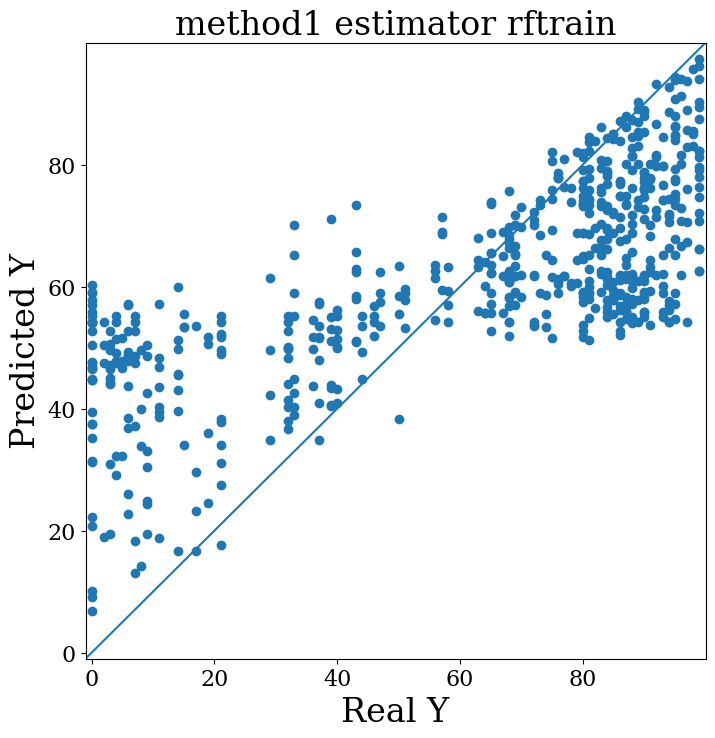

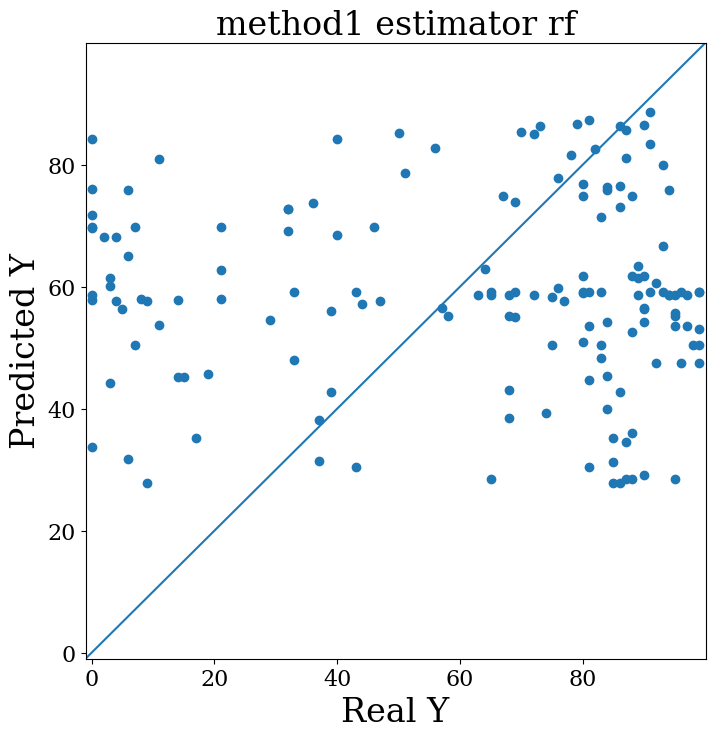

method2
RandomForestRegressor(max_depth=50, max_features=None, n_estimators=10)
RandomForestRegressor(max_features='log2', n_estimators=200)
RandomForestRegressor(max_depth=5, max_features='log2', n_estimators=10)
RandomForestRegressor(max_depth=5, max_features='log2', n_estimators=300)
RandomForestRegressor(max_depth=5, max_features='log2', n_estimators=10)


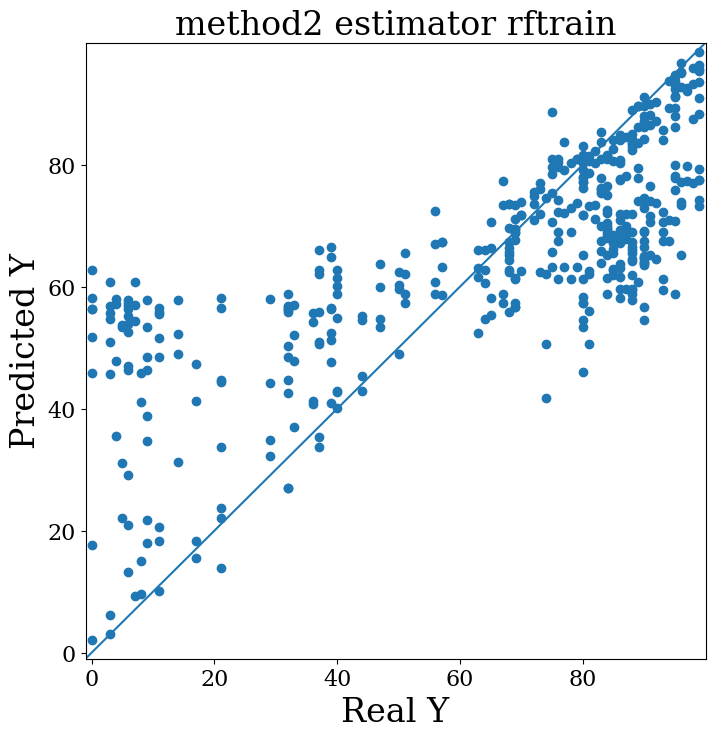

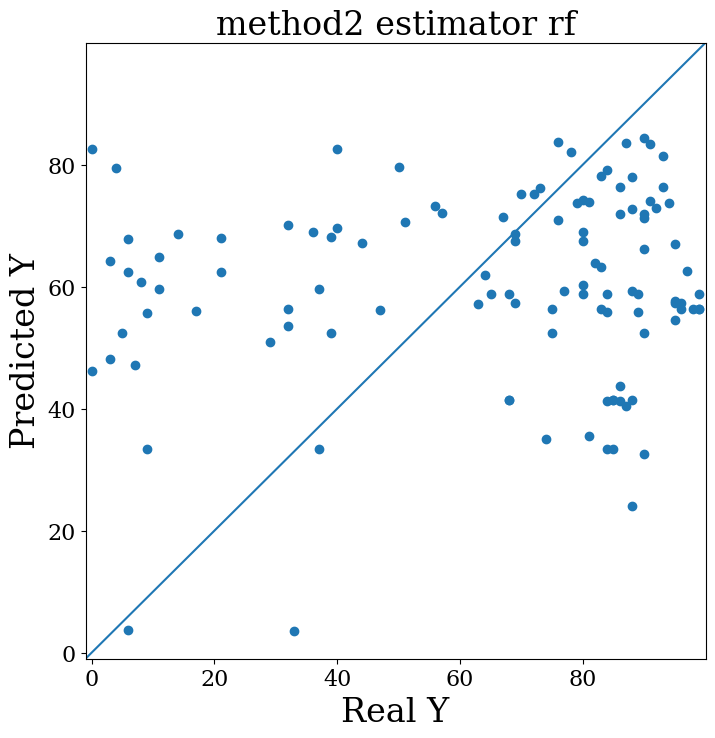

method3
RandomForestRegressor(max_depth=5, max_features=None, n_estimators=10)
RandomForestRegressor(max_depth=5, max_features='log2')
RandomForestRegressor(max_features='log2', n_estimators=10)
RandomForestRegressor(max_features='log2', n_estimators=10)
RandomForestRegressor(max_depth=50, max_features=None, n_estimators=10)


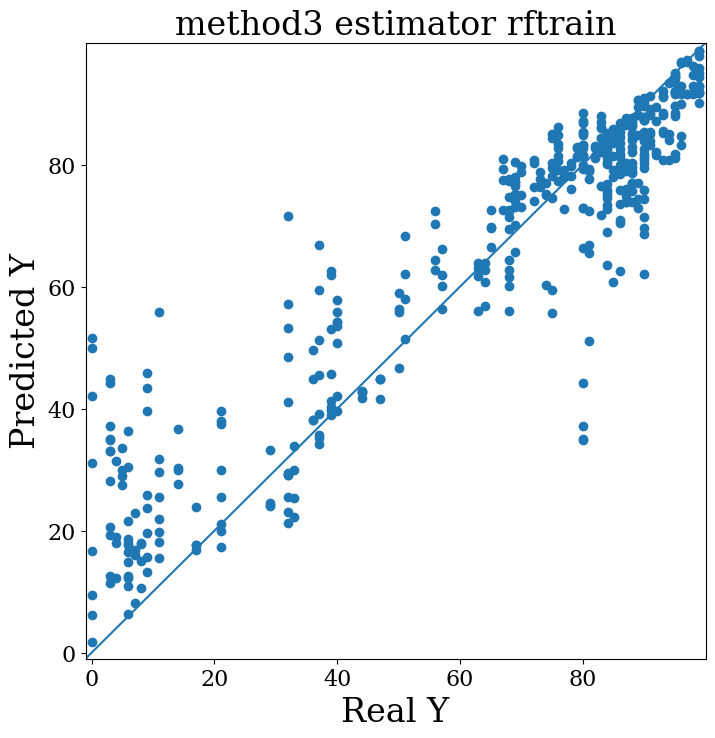

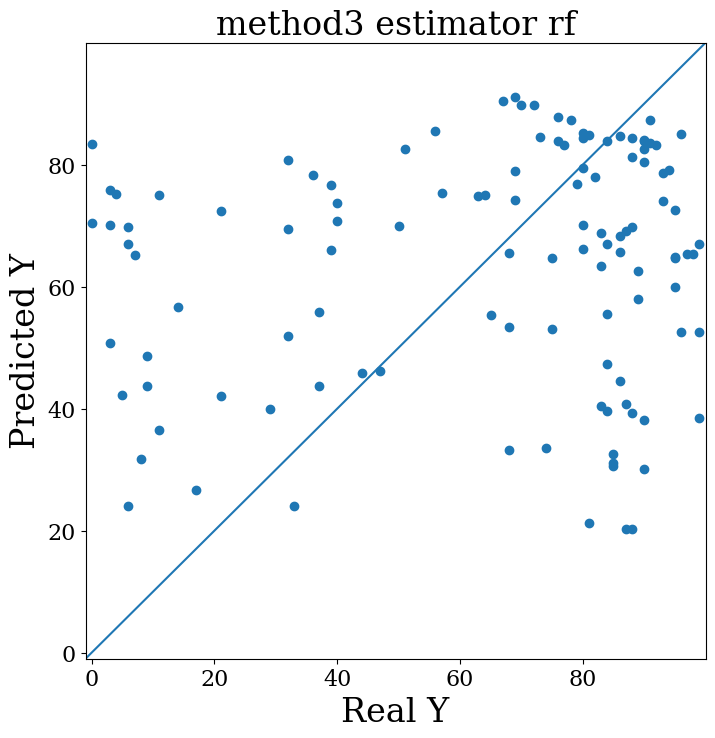

,method1,method2,method3
r2_train,0.501860,0.560404,0.839856
r2,-0.722933,-1.782451,-1.713012
rmse,36.601566,32.463086,32.701722
mae,31.206490,27.629789,27.451393


In [94]:
# rf
from sklearn.ensemble import RandomForestRegressor
# ハイパーパラメータ:https://tatsu-mk2.hatenablog.jp/entry/2019/05/04/185733
rf = RandomForestRegressor()
param_grid = {'n_estimators':[10, 100, 200, 300], 'max_depth':[5, 10, 50, None], 'max_features': ["sqrt", "log2", None]}
scores = []
for method, xy in each_method_dataset.items():
    print(method)
    results = predict_score(* xy, param_grid, rf)
    score = plot_result(results, method, 'rf')
    scores.append(score)
display(pd.concat(scores,axis=1))

removed_promoter
PLSRegression(max_iter=1000, n_components=3, scale=False)
PLSRegression(max_iter=1000, n_components=3, scale=False)
PLSRegression(max_iter=1000)
PLSRegression(max_iter=1000, scale=False)
PLSRegression(max_iter=1000, scale=False)


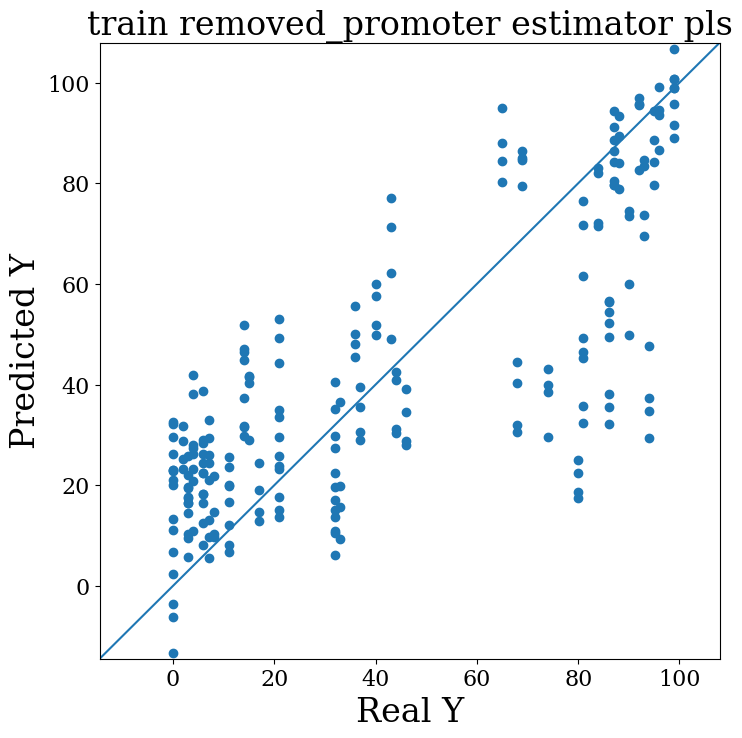

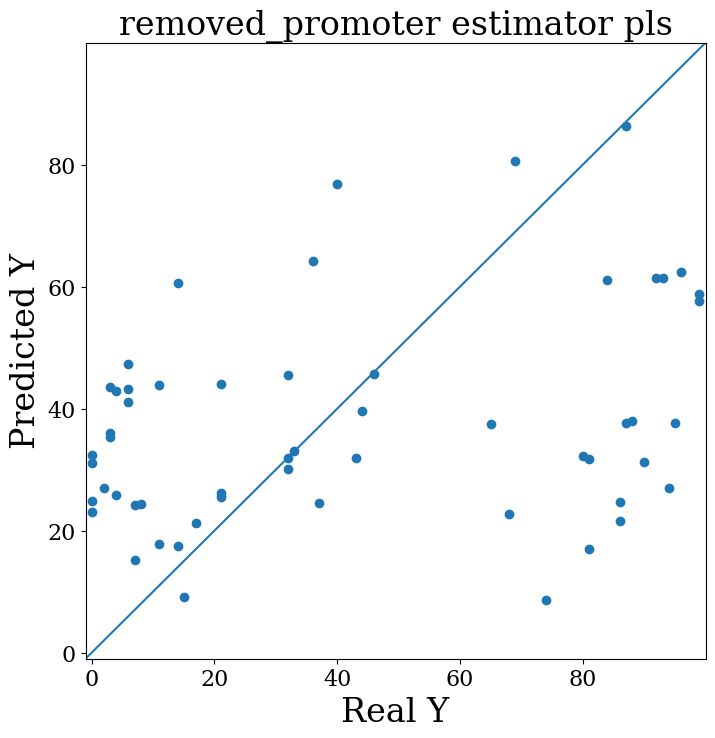

,removed_promoter
r2_train,0.606954
r2,-0.406414
rmse,34.045010
mae,29.200288


In [220]:
# PLS
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression()
param_grid = {'n_components': [2, 3, 4, 5, 6], 'scale':[True, False], 'max_iter': [1000]}

scores = []
for method, xy in each_method_dataset.items():
    print(method)
    results = predict_score(* xy, param_grid, pls)
    score = plot_result(results, method, 'pls')
    scores.append(score)
display(pd.concat(scores,axis=1))

In [ ]:
# LASSO
from sklearn.linear_model import Lasso
# ハイパーパラメータ:https://qiita.com/damyarou/items/10a43358a96ed5d13832
lasso = Lasso()
param_grid = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [100000]}

scores = []
# for method, xy in each_method_dataset.items():
for method, xy in [('method4', [X_improved,y_improved])]:
    print(method)
    results = predict_score(* xy, param_grid, lasso)
    score = plot_result(results, method, 'lasso')
    scores.append(score)
display(pd.concat(scores,axis=1))

In [ ]:
# 勾配ブースティング
from sklearn.ensemble import GradientBoostingRegressor

# ハイパーパラメータ:https://qiita.com/maskot1977/items/c648e398b3b86cb68ae5
gbr = GradientBoostingRegressor()
param_grid = [{
    'learning_rate':[0.1,0.2],
    'n_estimators':[20,100],
    'max_depth':[3,5]
}]

scores = []
for method, xy in each_method_dataset.items():
    print(method)
    results = predict_score(* xy, param_grid, gbr)
    score = plot_result(results, method, 'gbr')
    scores.append(score)
display(pd.concat(scores,axis=1))

In [ ]:
GPR
GBDT
XGB

In [ ]:
pls = PLSRegression()
param_grid = {'n_components': [2, 3, 4, 5, 6], 'scale':[True, False], 'max_iter': [1000]}

scores = []
for method, xy in each_method_dataset.items():
    print(method)
    results = predict_easy(* xy, param_grid, pls)
    print(results)
    score = plot_result(results, method, 'pls')
    scores.append(score)
display(pd.concat(scores,axis=1))

# ADの追加
one class support vector machine (OCSVM)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import pickle

# データの読み込み
X_train,X_test, y_train,y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=0)


# 記述子名のリストを取り出す
descriptor_label = X_train.columns

clf = OneClassSVM(nu = 0.2)
# 1 か -1 
y_train_class = clf.fit_predict(X_train)
y_test_class = clf.predict(X_test)

# 分割面からの距離を算出
clf.decision_function(X_test)

array([ 0.11274001, -0.2896557 , -0.29714458,  0.74208022, -0.28394993,
       -1.28789978, -0.08858633,  0.96494293, -0.07693155,  0.25081401,
        0.41941733, -0.01456761, -0.00368204, -0.01712146,  0.91098068,
        0.11879925, -0.14822101, -0.1904661 ,  0.29510524,  1.02156158,
       -0.11308828,  0.40650499,  0.27191844])

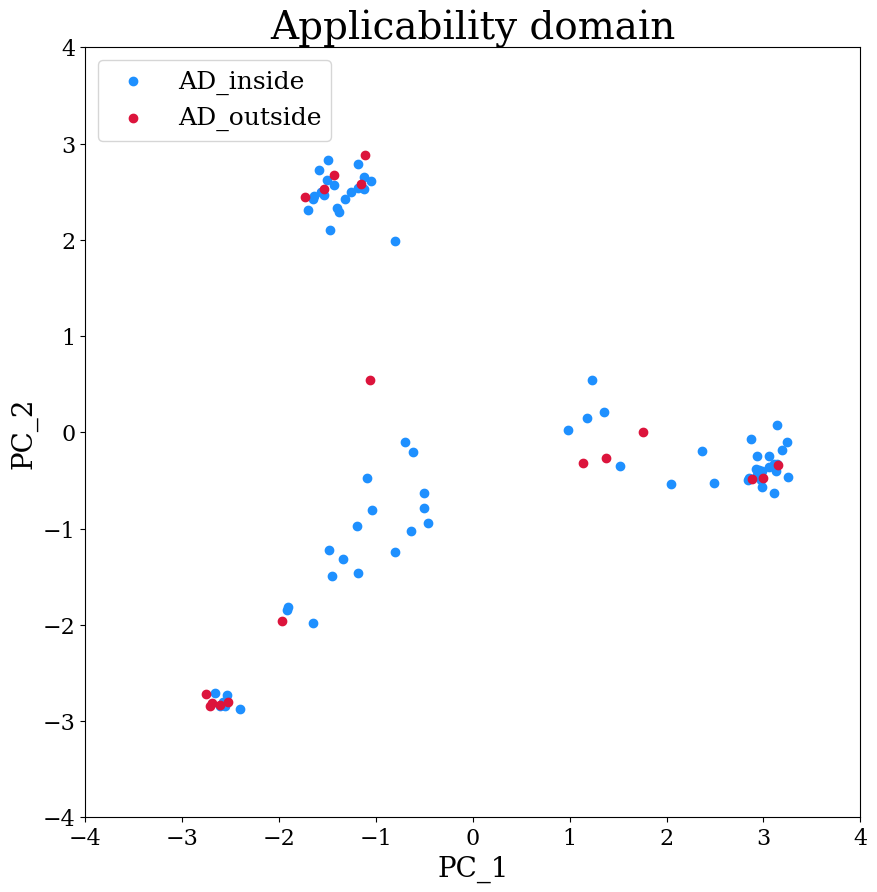

In [225]:
# データの分布を主成分分析（PCA）で表現してみる
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.rcParams['font.family'] = "DejaVu Serif"

fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(1, 1, 1)

# グラフのタイトル
ax.set_title("Applicability domain", fontsize = 28)

ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.tick_params(axis = "x", labelsize = 16)
ax.tick_params(axis = "y", labelsize = 16)
ax.set_xlabel("PC_1", fontsize = 20)
ax.set_ylabel("PC_2", fontsize = 20)


ax.scatter(X_train_pca[y_train_class == 1, 0], X_train_pca[y_train_class == 1, 1], c = "dodgerblue", label = "AD_inside")
ax.scatter(X_train_pca[y_train_class == -1, 0], X_train_pca[y_train_class == -1, 1], c = "crimson", label = "AD_outside")

ax.legend(loc = "upper left", fontsize = 18)

plt.show()

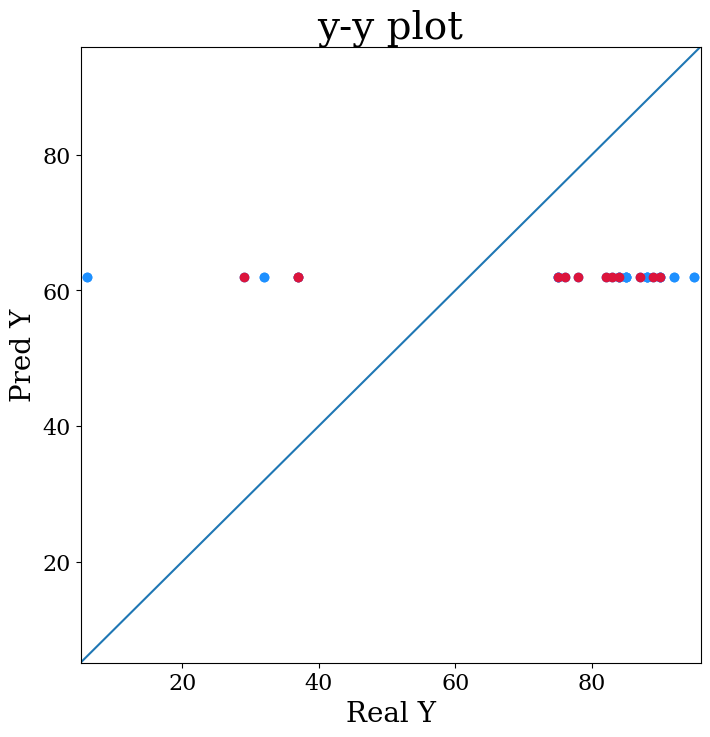

AD内：  -0.21191532012350622
AD外：  -0.15878763563539477


In [68]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=100, max_iter=10000)
lasso.fit(X_train,y_train)
y_pred  = lasso.predict(X_test)

yvalues = np.concatenate([y_test.values.flatten(), y_pred.flatten()])
ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
fig = plt.figure(figsize=(8, 8))
plt.rcParams['font.family'] = "DejaVu Serif"

plt.title("y-y plot", fontsize=28)
plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)

plt.xlabel('Real Y', fontsize=20)
plt.ylabel('Pred Y', fontsize=20)
plt.tick_params(labelsize=16)
plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])


plt.scatter(y_test, y_pred, c = "dodgerblue")
plt.scatter(y_test[y_test_class == 1], y_pred[y_test_class == 1], c = "dodgerblue", label = "AD_inside")
plt.scatter(y_test[y_test_class == -1], y_pred[y_test_class == -1], c = "crimson", label = "AD_outside")

plt.show()

print('AD内： ',r2_score(y_test[y_test_class == 1], y_pred[y_test_class == 1]))
print('AD外： ',r2_score(y_test[y_test_class == -1], y_pred[y_test_class == -1]))


In [184]:
X_improved = pd.read_csv('X_improved.csv', header=0,index_col=0).iloc[:,1:]
y_improved = pd.read_csv('y_improved.csv', header=0,index_col=0)

In [185]:
display(X_improved.head(5))
display(y_improved.head(5))

,R2_C,R2_H,R2_Ph,under_Ar,under_O2,under_air,organocatalyst(mol%),temp(℃),time(h),0_R1-,...,2038_organocatalyst,2039_organocatalyst,2040_organocatalyst,2041_organocatalyst,2042_organocatalyst,2043_organocatalyst,2044_organocatalyst,2045_organocatalyst,2046_organocatalyst,2047_organocatalyst
0,0,1,0,0,1,0,-1.522195,-0.967349,-0.392607,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,-1.522195,-0.967349,-0.392607,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,-1.522195,-0.967349,-0.392607,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,-1.522195,-0.967349,-0.392607,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,-1.522195,-0.967349,-0.392607,0,...,0,0,0,0,0,0,0,0,0,0


,収率(%)
0,87.0
1,76.0
2,93.0
3,90.0
4,91.0
